In [4]:
import pandas as pd
from pandas import MultiIndex
from geo_kpe_multidoc import GEO_KPE_MULTIDOC_OUTPUT_PATH, GEO_KPE_MULTIDOC_CACHE_PATH
import os
from matplotlib import pyplot as plt
import joblib

In [2]:
# geo.parquet.gzip -> longformer_4096_128_130 -> MKDUC01 -> inv_dis(a=17000)
df = pd.read_parquet(os.path.join(GEO_KPE_MULTIDOC_OUTPUT_PATH, "geo.parquet.gzip"))

In [4]:
df.loc[df.N > 1, ["N","moran_i", 'geary_c', 'getis_g']].corr()

,N,moran_i,geary_c,getis_g
N,1.000000,-0.115987,0.218137,-0.297767
moran_i,-0.115987,1.000000,-0.926880,0.422043
geary_c,0.218137,-0.926880,1.000000,-0.691570
getis_g,-0.297767,0.422043,-0.691570,1.000000


In [5]:
df.loc[:, ["N","moran_i", 'geary_c', 'getis_g']].corr()

,N,moran_i,geary_c,getis_g
N,1.000000,-0.735276,0.748792,-0.253315
moran_i,-0.735276,1.000000,-0.996745,0.289871
geary_c,0.748792,-0.996745,1.000000,-0.305792
getis_g,-0.253315,0.289871,-0.305792,1.000000


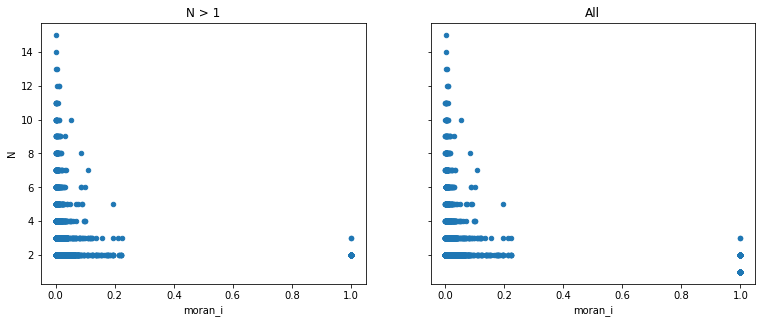

In [19]:
plt.rcParams['figure.figsize'] = (12.8, 4.8)

_, ax = plt.subplots(1, 2, sharey='row')
df.loc[:, ["N","moran_i"]].plot(kind='scatter', x='moran_i', y='N', ax=ax[1], title="All")
df.loc[df.N > 1, ["N","moran_i"]].plot(kind='scatter', x='moran_i', y='N', ax=ax[0], title="N > 1")
plt.show()

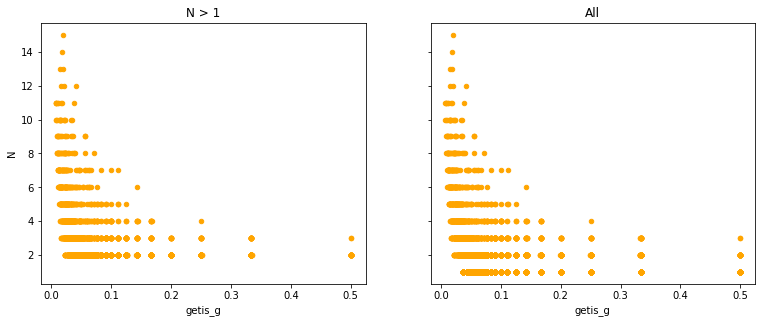

In [21]:
plt.rcParams['figure.figsize'] = (12.8, 4.8)

_, ax = plt.subplots(1, 2, sharey='row')
df.loc[:, ["N","getis_g"]].plot(kind='scatter', x='getis_g', y='N', ax=ax[1], title="All", color="orange")
df.loc[df.N > 1, ["N","getis_g"]].plot(kind='scatter', x='getis_g', y='N', ax=ax[0], title="N > 1", color='orange')
plt.show()


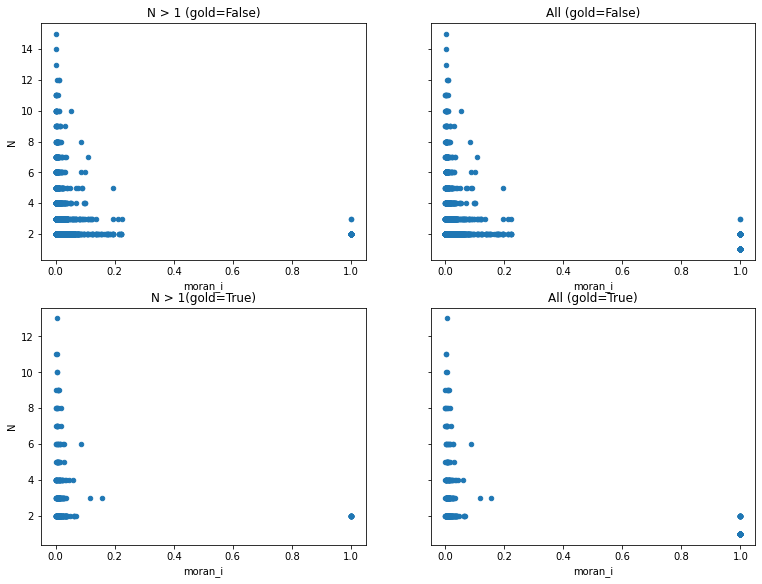

In [40]:
plt.rcParams['figure.figsize'] = (12.8, 4.8*2)

_, ax = plt.subplots(2, 2, sharey='row')

df.loc[df.gold == False, ["N","moran_i"]].plot(kind='scatter', x='moran_i', y='N', ax=ax[0,1], title="All (gold=False)")
df.loc[df.N.gt(1) & (df.gold==False), ["N","moran_i"]].plot(kind='scatter', x='moran_i', y='N', ax=ax[0, 0], title="N > 1 (gold=False)")
df.loc[df.gold ==True, ["N","moran_i"]].plot(kind='scatter', x='moran_i', y='N', ax=ax[1,1], title="All (gold=True)")
df.loc[df.N.gt(1) & (df.gold==True), ["N","moran_i"]].plot(kind='scatter', x='moran_i', y='N', ax=ax[1, 0], title="N > 1(gold=True)")
plt.show()

In [41]:
df.loc[df.N.gt(1) & (df.gold==False), ["N","moran_i"]].corr()

,N,moran_i
N,1.000000,-0.111324
moran_i,-0.111324,1.000000


In [42]:
df.loc[df.N.gt(1) & (df.gold==True), ["N","moran_i"]].corr()

,N,moran_i
N,1.000000,-0.168392
moran_i,-0.168392,1.000000


In [43]:
df.loc[(df.gold==True), ["N","moran_i"]].corr()

,N,moran_i
N,1.000000,-0.712475
moran_i,-0.712475,1.000000


In [50]:
df.loc[(df.moran_i < 0.2), "semantic_score"].mean(), df.loc[(df.moran_i < 0.2) & df.gold == True, "semantic_score"].mean()

(0.49380147, 0.56003606)

In [49]:
df.loc[(df.moran_i > 0.2), "semantic_score"].mean(), df.loc[(df.moran_i > 0.2) & df.gold == True, "semantic_score"].mean()

(0.43134874, 0.49912134)

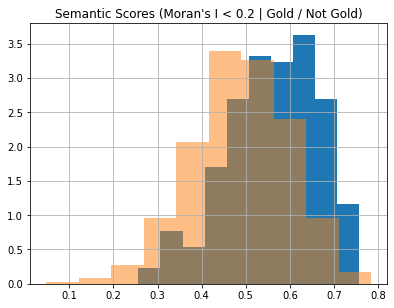

In [76]:
plt.rcParams['figure.figsize'] = (6.4, 4.8)
df.loc[(df.moran_i < 0.2) & (df.gold == True), "semantic_score"].hist(density=True)
df.loc[(df.moran_i < 0.2) & (df.gold == False), "semantic_score"].hist(alpha=0.5, density=True)
plt.title("Semantic Scores (Moran's I < 0.2 | Gold / Not Gold)")
plt.show()

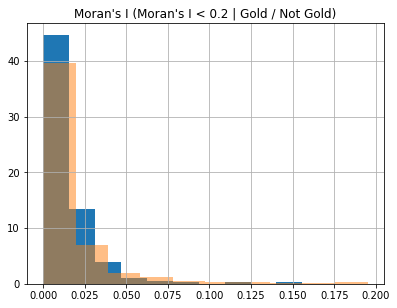

In [75]:
plt.rcParams['figure.figsize'] = (6.4, 4.8)
df.loc[(df.moran_i < 0.2) & (df.gold == True), "moran_i"].hist(density=True)
df.loc[(df.moran_i < 0.2) & (df.gold == False), "moran_i"].hist(alpha=0.5, density=True)
plt.title("Moran's I (Moran's I < 0.2 | Gold / Not Gold)")
plt.show()

<AxesSubplot:>

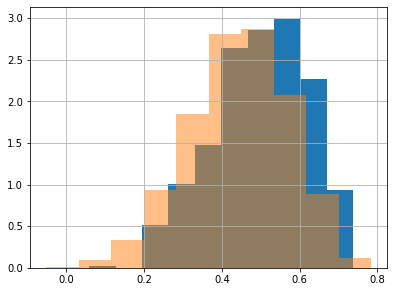

In [74]:
df.loc[(df.moran_i > 0.2) & df.gold == True, "semantic_score"].hist(density=True)
df.loc[(df.moran_i > 0.2) & df.gold == False, "semantic_score"].hist(alpha=0.5, density=True)

# KPE Performance with Moran'I

In [5]:
experiment = "MKDUC01-MDKPERank-Longformer-4096-128-130"
df = pd.read_parquet(os.path.join(GEO_KPE_MULTIDOC_OUTPUT_PATH, "geo.parquet.gzip"))
gold = joblib.load(os.path.join(GEO_KPE_MULTIDOC_CACHE_PATH, experiment, "MKDUC01-gold-20230501.pkl"))

In [43]:
from geo_kpe_multidoc.evaluation.evaluation_tools import postprocess_res_labels, postprocess_dataset_labels, evaluate_kp_extraction
import nltk

stemmer = nltk.stem.PorterStemmer()
lemmer = "en"


def df_to_model_results(df, gold_df, dataset_name):
    model_results = {dataset_name: []}
    true_labels = {dataset_name: []}
    for topic in df.index.get_level_values(0).unique():
        model_results[dataset_name].append((df.loc[topic, ["semantic_score"]].sort_values("semantic_score", ascending=False).to_records(), df.loc[topic].index.to_list()))
        true_labels[dataset_name].append(gold_df[topic])
    return model_results, true_labels


                       Precision    Recall       F1        MAP      nDCG    Precision_5    Recall_5       F1_5    Precision_10    Recall_10      F1_10    Precision_15    Recall_15     F1_15
-------------------  -----------  --------  -------  ---------  --------  -------------  ----------  ---------  --------------  -----------  ---------  --------------  -----------  --------
MKDUC01-moran_i<0.2      0.09085  0.261599  0.13031  0.0636596  0.235991       0.254545   0.0282955  0.0503488        0.227778     0.053082  0.0840504        0.206277    0.0704347  0.102053


In [52]:
model_results, true_labels = df_to_model_results(df, gold, "MKDUC01")

results = evaluate_kp_extraction(postprocess_res_labels(model_results=model_results, stemmer=stemmer, lemmer=lemmer),

                                 postprocess_dataset_labels(true_labels, stemmer=stemmer, lemmer=lemmer), 
                                 model_name="teste")

(results[["Recall", "MAP", "nDCG","F1_5", "F1_10", "F1_15"]].round(decimals=4)*100)

           Precision    Recall         F1        MAP      nDCG    Precision_5    Recall_5       F1_5    Precision_10    Recall_10      F1_10    Precision_15    Recall_15      F1_15
-------  -----------  --------  ---------  ---------  --------  -------------  ----------  ---------  --------------  -----------  ---------  --------------  -----------  ---------
MKDUC01    0.0470261  0.836295  0.0886334  0.0982698  0.487083       0.190909   0.0217844  0.0384132        0.177273    0.0376205  0.0605507        0.172727    0.0549484  0.0806836


,Recall,MAP,nDCG,F1_5,F1_10,F1_15
MKDUC01,83.63,9.83,48.71,3.84,6.06,8.07


In [53]:
df_moran_i = df[df.moran_i.lt(0.2)]

model_results, true_labels = df_to_model_results(df_moran_i, gold, "MKDUC01-moran_i<0.2")

results_i = evaluate_kp_extraction(postprocess_res_labels(model_results=model_results, stemmer=stemmer, lemmer=lemmer), postprocess_dataset_labels(true_labels, stemmer=stemmer, lemmer=lemmer), model_name="teste")

results_i[["Recall", "MAP", "nDCG","F1_5", "F1_10", "F1_15"]].round(decimals=4)*100

                       Precision    Recall       F1        MAP      nDCG    Precision_5    Recall_5       F1_5    Precision_10    Recall_10      F1_10    Precision_15    Recall_15     F1_15
-------------------  -----------  --------  -------  ---------  --------  -------------  ----------  ---------  --------------  -----------  ---------  --------------  -----------  --------
MKDUC01-moran_i<0.2      0.09085  0.261599  0.13031  0.0636596  0.235991       0.254545   0.0282955  0.0503488        0.227778     0.053082  0.0840504        0.206277    0.0704347  0.102053


,Recall,MAP,nDCG,F1_5,F1_10,F1_15
MKDUC01-moran_i<0.2,26.16,6.37,23.6,5.03,8.41,10.21


In [58]:

pd.concat([results, results_i])[["Precision", "Recall", "F1", "MAP", "nDCG","F1_5", "F1_10", "F1_15"]].round(decimals=4)*100


,Precision,Recall,F1,MAP,nDCG,F1_5,F1_10,F1_15
MKDUC01,4.70,83.63,8.86,9.83,48.71,3.84,6.06,8.07
MKDUC01-moran_i<0.2,9.08,26.16,13.03,6.37,23.60,5.03,8.41,10.21


In [60]:
results = pd.DataFrame()
for f in ["results-DUC2001-EmbedRankManual-Longformer-max4096-attw256-cpmaxpos130-20230505-180030.csv", 
          "results-debug-20230505-120301.csv", 
          "results-DUC2001-EmbedRankManual-Longformer-max4096-attw64-cpmaxpos130-20230505-181030.csv"]:
    
    r = pd.read_csv(os.path.join(GEO_KPE_MULTIDOC_OUTPUT_PATH, f))
    r.index = [f]

    results = pd.concat([results, r])

results[["Precision", "Recall", "F1", "MAP", "nDCG","F1_5", "F1_10", "F1_15"]].round(decimals=4)*100 


,Precision,Recall,F1,MAP,nDCG,F1_5,F1_10,F1_15
results-DUC2001-EmbedRankManual-Longformer-max4096-attw256-cpmaxpos130-20230505-180030.csv,7.94,80.56,13.56,13.58,39.47,9.53,13.95,14.89
results-debug-20230505-120301.csv,7.94,80.56,13.56,15.77,42.14,11.98,15.42,17.61
results-DUC2001-EmbedRankManual-Longformer-max4096-attw64-cpmaxpos130-20230505-181030.csv,7.94,80.56,13.56,16.09,42.49,12.35,16.39,17.88
